In [55]:
%load_ext autoreload
%autoreload 2

In [63]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
from grpglmnet.group_elnet import generate_group_elnet_data
from grpglmnet.group_basil import group_basil

In [313]:
seed = 0
n = 100
p = 1000
n_groups = p

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_elnet_data(
    n, p, n_groups, rho=0.0, svd_transform=False, group_split_type="even",
).values()
penalty = np.sqrt(group_sizes)

In [314]:
def solve_dual(X, y, groups, group_sizes, penalty, kkt_tol=0.05):
    n = X.shape[0]
    lmda = cp.Variable(n)
    expr = lmda @ y
    constraints = [
        cp.norm(X[:, groups[i] : groups[i] + group_sizes[i]].T @ lmda) <= penalty[i]    
        for i in range(len(groups))
    ]
    prob = cp.Problem(cp.Maximize(expr), constraints)
    result = prob.solve()

    beta_min_norm = X.T @ lmda.value
    beta_min_norm = np.concatenate([
        beta_min_norm[g : g + gs] if np.linalg.norm(beta_min_norm[g : g + gs]) >= pi * (1-kkt_tol) else np.zeros(gs)
        for pi, g, gs in zip(penalty, groups, group_sizes)
    ])
    S = np.array([
        X[:, g : g + gs] @ beta_min_norm[g : g + gs]
        for g, gs in zip(groups, group_sizes)
    ]).T
    c, _, _, _ = np.linalg.lstsq(S, y, rcond=None)
    beta_min_norm_star = np.repeat(c, group_sizes) * beta_min_norm

    return result, lmda.value, beta_min_norm_star
    
def solve_dual_alpha(X, y, groups, group_sizes, alpha, penalty, *args, **kwargs):
    if alpha == 1:
        return solve_dual(X, y, groups, group_sizes, penalty, *args, **kwargs)

    n = X.shape[0]
    lmda = cp.Variable(n)
    expr = lmda @ y - cp.sum([
        cp.pos(cp.norm(X[:, g : g + gs].T @ lmda) - pi * alpha)**2 / (2 * pi * (1-alpha)) 
        for pi, g, gs in zip(penalty, groups, group_sizes)
    ])
    prob = cp.Problem(cp.Maximize(expr))
    result = prob.solve(solver=cp.MOSEK)
    
    beta_min_norm = X.T @ lmda.value
    norms = np.array([
        np.linalg.norm(beta_min_norm[g : g + gs])
        for g, gs in zip(groups, group_sizes) 
    ])
    beta_min_norm = np.concatenate([
        ((1 - pi * alpha / norms_i) / (pi * (1-alpha))) * beta_min_norm[g : g + gs]
        if norms_i > pi * alpha
        else np.zeros(gs)
        for norms_i, pi, g, gs in zip(norms, penalty, groups, group_sizes)
    ])
    return result, lmda.value, beta_min_norm

In [321]:
alpha = 0.1

In [322]:
result, lmda_value, beta_min_norm_star = solve_dual_alpha(X, y, groups, group_sizes, alpha, penalty)
result, lmda_value 

(0.6278034741008065,
 array([ 0.09867777,  0.12016547,  0.08115577,  0.05155598,  0.02320482,
        -0.16720069, -0.10855349, -0.04927667,  0.03202033, -0.05539794,
         0.08850629,  0.14349795, -0.14792271, -0.00274422, -0.10143578,
         0.00157554, -0.11509177,  0.0285526 , -0.03942013,  0.10073425,
         0.04531017, -0.0014703 , -0.01082552, -0.03825731,  0.05902547,
        -0.09513998,  0.07712758,  0.0853057 ,  0.04803187, -0.12651938,
         0.11636434, -0.12767567, -0.07648517,  0.07229093,  0.05248642,
        -0.10567023, -0.02175851,  0.01744582,  0.03247758,  0.03859506,
         0.16244759, -0.05959567,  0.01374247,  0.02958823,  0.00047705,
        -0.10835211, -0.08756271, -0.19305216, -0.12050958,  0.00641712,
         0.04713583, -0.07666892,  0.05100148,  0.01179001,  0.03608467,
        -0.01611936, -0.03274319, -0.08796721,  0.02905892,  0.02715226,
         0.05896229,  0.00048441,  0.00850342,  0.04232975, -0.10951636,
         0.10723573,  0.035997

In [323]:
out_naive = group_basil(
    X, y, groups, group_sizes, 
    alpha=alpha,
    penalty=penalty,
    method='naive', 
    max_n_cds=int(1e6), 
    n_lambdas_iter=5,
    use_strong_rule=True,
    verbose_diagnostic=False,
    thr=1e-10,
)

100%|██████████| 1000/1000 [00:00<00:00, 4338.00it/s]


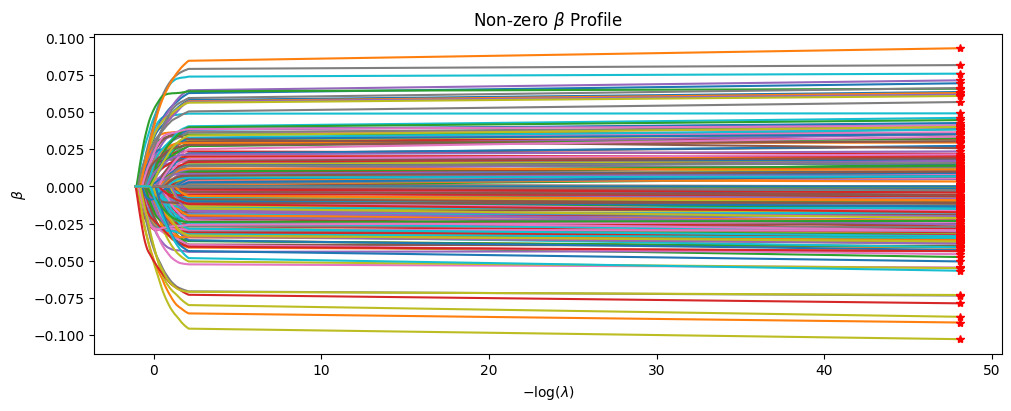

In [324]:
out = out_naive

lmdas = np.concatenate([out['lmdas'], [out['lmdas'][-1] * 1e-20]])
_, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
for j in tqdm(range(out['betas'].shape[0])):
    beta_j = out['betas'][j]
    if beta_j.count_nonzero() > 0:
        bj = np.array(beta_j.todense()).squeeze()
        bj = np.concatenate([bj, [beta_min_norm_star[j]]])
        axes.plot(-np.log(lmdas), bj)
for j in tqdm(range(beta_min_norm_star.shape[0])):
    axes.plot(-np.log(lmdas[-1]), beta_min_norm_star[j], marker='*', color='red') 
axes.set_title('Non-zero $\\beta$ Profile')
axes.set_xlabel('$-\log(\lambda)$')
axes.set_ylabel('$\\beta$')
plt.show()